# Data Visualization

Matplotlib provides a lot of control over plotting details, but requires writing code that handles those details. Seaborn is designed to work with DataFrames and to make useful plotting be as simple as possible.

## Preparing data for plotting

To plot data in a DataFrame, we will first need to load the data and do any necessary data cleaning and reorganization. We will prepare the Osth & Fox (2019) using methods that we have discussed before.

Let's load the Osth & Fox (2019) dataset, then clean it as we've done previously. This time, we'll use the `datascipsych.datasets.clean_osth` function to prepare the DataFrame. We'll also use `filter` to get just the trials from the test phase.

In [1]:
import polars as pl
from datascipsych import datasets
raw = pl.read_csv(datasets.get_dataset_file("Osth2019"))
data = datasets.clean_osth(raw).filter(pl.col("phase") == "test")
data.head()

subj,cycle,phase,trial,type,word1,word2,response,RT,correct,lag,probe_type
i64,i64,str,i64,str,str,str,i64,f64,i64,i64,str
101,0,"""test""",-1,"""rearranged""","""waste""","""degree""",0,2.312,1,2,"""lure"""
101,0,"""test""",0,"""rearranged""","""needed""","""able""",0,3.542,1,1,"""lure"""
101,0,"""test""",1,"""rearranged""","""single""","""clean""",0,2.084,1,3,"""lure"""
101,0,"""test""",2,"""rearranged""","""train""","""useful""",0,1.669,1,2,"""lure"""
101,0,"""test""",3,"""rearranged""","""knees""","""various""",0,2.326,1,5,"""lure"""


Next, we'll need to calculate the descriptive statistics that we want to plot. First, we'll calculate the hit rate and false-alarm rate for each subject.

In [2]:
perf = (
    data.group_by("subj", "probe_type")
    .agg(
        pl.col("response").mean(), 
        pl.col("RT").mean(),
    )
    .sort("subj", "probe_type")
)
perf.head()

subj,probe_type,response,RT
i64,str,f64,f64
101,"""lure""",0.108333,1.924008
101,"""target""",0.76569,1.646904
102,"""lure""",0.241667,1.088396
102,"""target""",0.2875,1.061537
103,"""lure""",0.091667,1.415992


Now that we have calculated our measures of interest, we are ready to create a plot to visualize responses in the lure and target conditions.

## Seaborn plots

In Seaborn, plots are usually created by passing a DataFrame to a function and specifying how the variables in the DataFrame should be used in the plot. There are three main types of plot:

Distribution
: plot the distribution of one or more variables using a histogram or density plot.

Categorical
: plot a distribution or central tendency for multiple variables side-by-side.

Relational
: plot the relationship between two or more variables.

## Distribution plots

In Seaborn, there are multiple ways to visualize a distribution of observations. Before, we used `plt.hist` to make histograms. Seaborn lets us quickly make histograms from DataFrames more flexibly.

To work with Seaborn, we must first import it. The Seaborn package is named after [Samuel Norman Seaborn](https://en.wikipedia.org/wiki/Sam_Seaborn), the fictional White House Communications Director on the TV show The West Wing. The conventional way to abbreviate Seaborn when importing it is using `sns`, after the initials of the package's namesake.

In [3]:
import seaborn as sns
sns.set_style("ticks")

To make a distribution plot, we can use the `displot` function. The `kind` variable determines how the distribution is visualized.

histplot
: summarize data in bins using a histogram.

kdeplot
: summarize data with a kernel density estimation plot.

We can create a histogram by calling `displot` and setting the `kind` to `"hist"`. We'll first make a histogram of mean response time across subjects. We set `data` to the DataFrame with the data we want to plot, and `x` to the name of the column of `data` we want to plot. Note that we end the command with a semicolon (`;`); this suppresses printing of the Seaborn object produced by `sns.displot`.

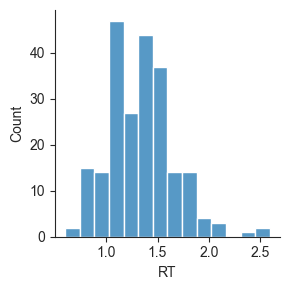

In [20]:
sns.displot(data=perf, x="RT", kind="hist", height=3);

Note that Seaborn does some work for us, getting the data from the DataFrame and making a histogram, and labeling the axes based on our data.

Sometimes, it's helpful to compare multiple distributions on the same plot. We can do this by setting the `hue` parameter, which splits up the data and plots each group with a different color.

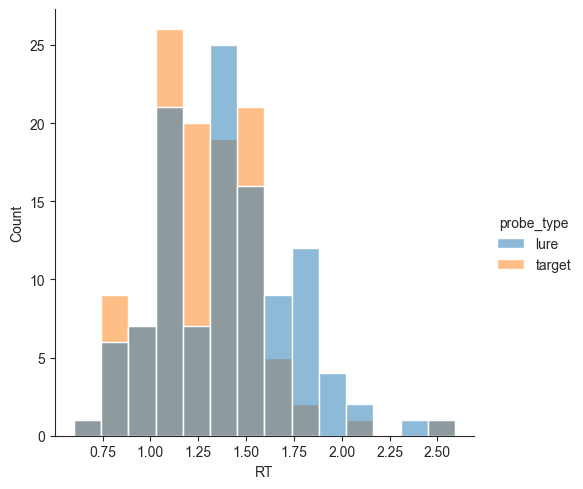

In [5]:
sns.displot(data=perf, x="RT", hue="probe_type", kind="hist");

Seaborn automatically determines good visualization properties for us, selecting two highly contrasting colors and plotting the overlap between the histograms using a different color. This makes it easy to see that response times for lure and target trials are similar, but target trial responses tend to be faster.

Histograms split the data into bins and count up the number of observations in each bin. Seaborn also supports kernel density estimation plots, which use a *kernel* instead of bins. This method smooths the underlying data to give an estimate of how dense observations are at each point.

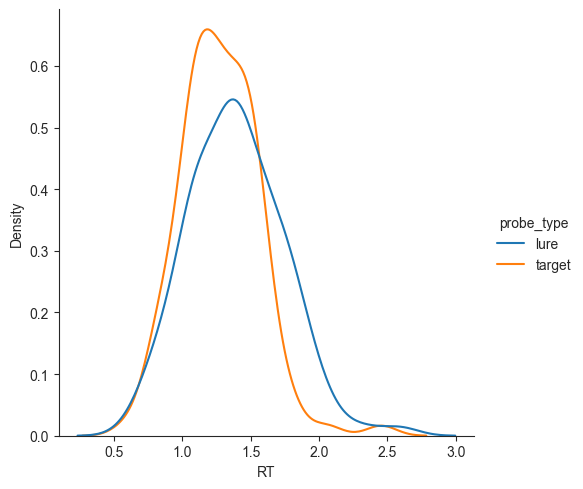

In [6]:
sns.displot(data=perf, x="RT", hue="probe_type", kind="kde");

This type of plot can sometimes make it easier to compare conditions. However, it is important to keep in mind that a KDE plot does not show the underlying data directly; instead, it estimates a smoothed version of the distribution and plots that.

We can #save the figure to a file using the Seaborn object that is returned by its plotting functions. First, we assign the Seaborn FacetGrid object to a variable called `g`. Then, we use the `savefig` method to save out the file. The type of file is automatically determined by the file extension we provde. Here, we'll save to a PDF file. PDF files are often a good choice for plots, because they store a *vector* format that does not have a resolution. This means that we can zoom in as much as we want without seeing any pixels.

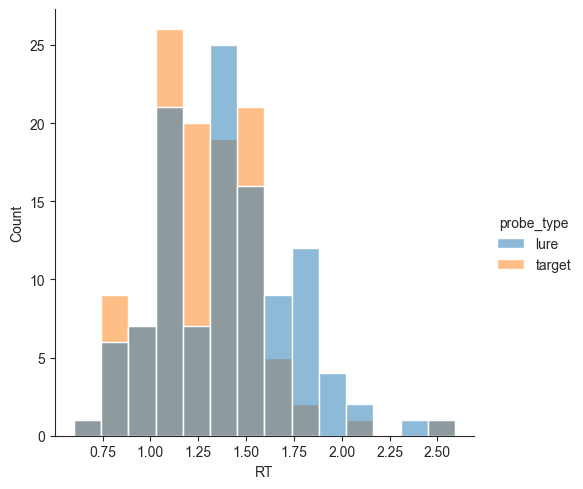

In [7]:
g = sns.displot(data=perf, x="RT", hue="probe_type", kind="hist")
# g.savefig("histogram.pdf")  # uncomment to save figure

See the Seaborn documentation for more information about [visualizing distributions](https://seaborn.pydata.org/tutorial/distributions.html).

## Categorical plots

In Seaborn, categorical plots are used to visualize one or more distributions (usually at least two). For example, "categories" might correspond to different experimental conditions.

A common type of plot for visualizing different conditions is called a *bar plot*. Let's make a bar plot showing the probability of responding "old" in the target and lure conditions.

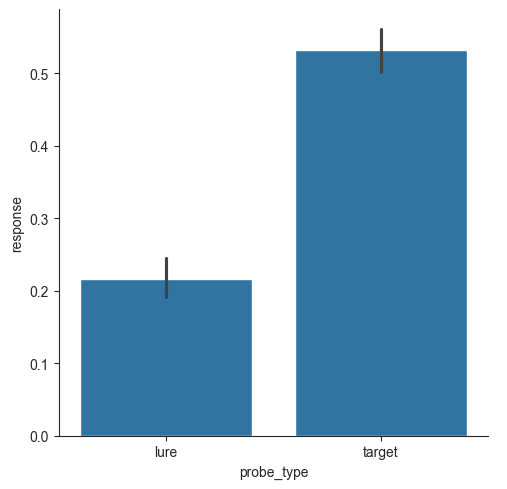

In [8]:
sns.catplot(data=perf, x="probe_type", y="response", kind="bar");

To make this plot, we indicated that the x-axis should be based on the `probe_type` column and the y-axis should be based on the `response` column. The `barplot` function automatically split our data into "lure" and "target" bins and calculated the mean response. 

It also calculated 95% confidence intervals using a bootstrap method, which estimate how much the mean would vary if we repeated the same experiment and collected the same measures over and over. To create a bootstrap confidence interval, Seaborn takes the distribution of observations and randomly samples from it with replacement to make a new set of observations. Then it calculates the mean of this *bootstrap* distribution. It does this 1000 times and then plots a line showing the middle 95% of means from the bootstrap.

We can make exactly the same plot using a horizontal bar plot, if we exchange the x-axis and y-axis inputs. This is sometimes useful if the labels of the different categories are long, as long labels are harder to fit on the x-axis.

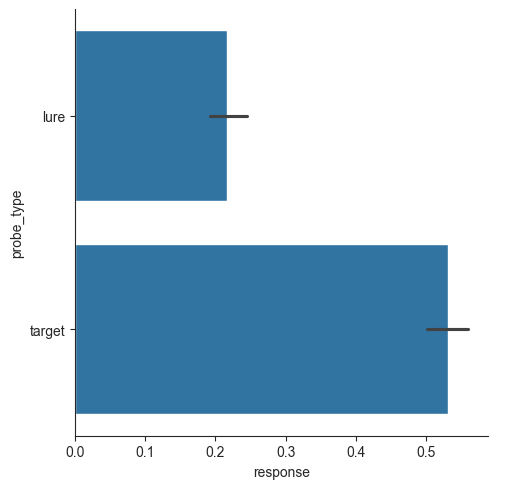

In [9]:
sns.catplot(data=perf, x="response", y="probe_type", kind="bar");

Bar plots just show the means and uncertainty in the means. We can also make *swarm plots* that show the individual points in the different distributions. This is more complicated to look at, but it gives a more realistic sense of the data.

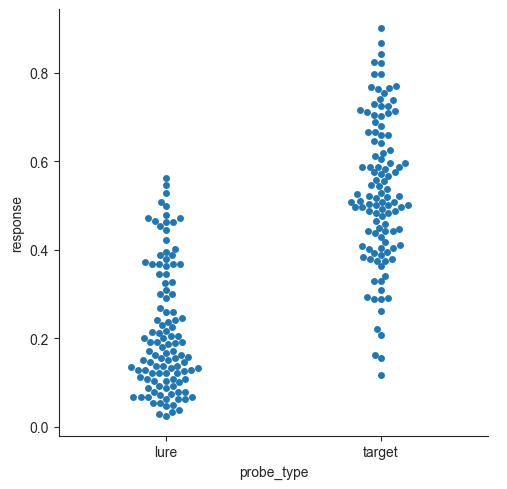

In [10]:
sns.catplot(data=perf, x="probe_type", y="response", kind="swarm");

A similar type of plot is called a *strip plot*. Instead of plotting points that don't overlap, points are plotted within a strip with some jitter.

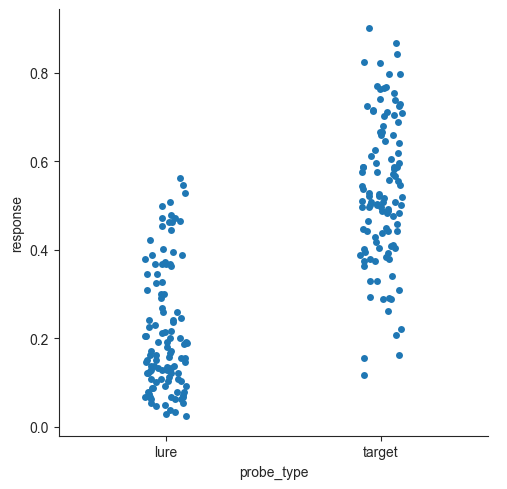

In [11]:
sns.catplot(data=perf, x="probe_type", y="response", kind="strip");

Strip plots sometimes work better than swarm plots when there are a lot of observations that bunch up and make the swarm plot too wide for the plot.

Another common type of plot is called a *box plot*. It shows more detail than a bar plot, but does not show individual points like a swarm plot. The box shows the middle *quartiles* of the distribution. The quartiles include the 25th, 50th, and 75th percentiles. Box plots separate out points that are near the central tendency of the distribution from *outliers*. 

Outliers are determined based on the interquartile range (IQR), which is the difference between the 75th and 25th percentiles.

Points are considered outliers if they are more than 1.5 IQRs away from the nearest quartile. The whiskers at the top and bottom show the range of points that are *not* outliers. Any outliers are plotted as individual points.

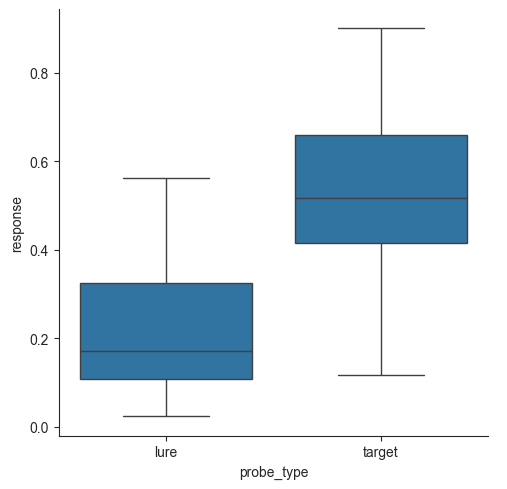

In [12]:
g = sns.catplot(data=perf, x="probe_type", y="response", kind="box")

Swarm and strip plots give a better sense of the underlying data, but box plots make the range and median of the data easy to see.

Sometimes we care about multiple dimensions of the data. For example, we can split the response times up by the probe type and type of response ("old" or "new"). First, we'll get the data in shape. This example uses a *conditional* expression to relabel the responses of 0 and 1 as "new" and "old", respectively.

In [13]:
conditions = (
    data.with_columns(
        response=pl.when(pl.col("response") == 0).then(pl.lit("new")).otherwise(pl.lit("old"))
    )
    .group_by("subj", "probe_type", "response")
    .agg(pl.col("RT").mean())
    .sort("subj", "probe_type", "response")
)
conditions.head(4)

subj,probe_type,response,RT
i64,str,str,f64
101,"""lure""","""new""",1.913257
101,"""lure""","""old""",2.0125
101,"""target""","""new""",1.850839
101,"""target""","""old""",1.584497


How that we have our bins defined, we can use a bar plot to visualize how mean response time varies depending on probe type and response. We'll represent response using the *hue* parameter.

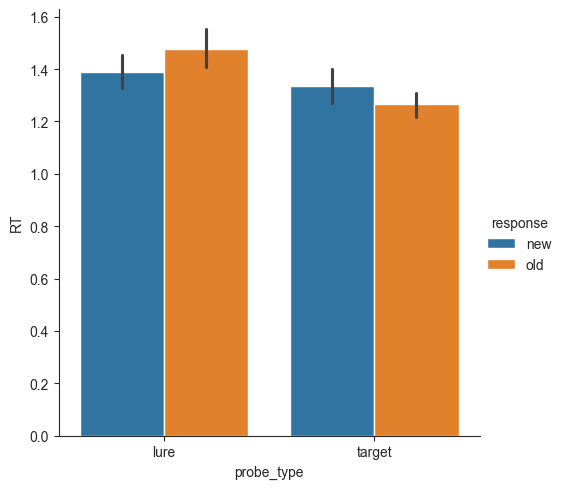

In [14]:
sns.catplot(data=conditions, x="probe_type", y="RT", hue="response", kind="bar");

From this plot, we can see that correct responses ("new" for lures, and "old" for targets) tend to be faster. Responses to targets also tend to be faster overall.

See the Seaborn documentation for more information about [visualizing categorical data](https://seaborn.pydata.org/tutorial/categorical.html).

## Relational plots

Relational plots are used to show a relationship between two variables. For example, you might be interested in whether two measures are correlated with one another, or how some variable changes over time.

Say we are interested in the relationship between response time on target and lure trials, across participants. Is speed on these different trials related? First, let's display the DataFrame to remind ourselves how the data are arranged.

In [15]:
perf.head()

subj,probe_type,response,RT
i64,str,f64,f64
101,"""lure""",0.108333,1.924008
101,"""target""",0.76569,1.646904
102,"""lure""",0.241667,1.088396
102,"""target""",0.2875,1.061537
103,"""lure""",0.091667,1.415992


We can use a pivot table to set up our variables of interest in different columns. Here, we'll make columns from the `probe_type` column and get the values from the `RT` column.

In [16]:
response_time = perf.pivot("probe_type", index="subj", values="RT")
response_time.head()

subj,lure,target
i64,f64,f64
101,1.924008,1.646904
102,1.088396,1.061537
103,1.415992,1.152863
104,1.102379,1.096696
105,1.331477,1.186833


We can use `relplot` to visualize this relationship. By default, `relplot` will make a scatterplot, with one point for each pair of observations.

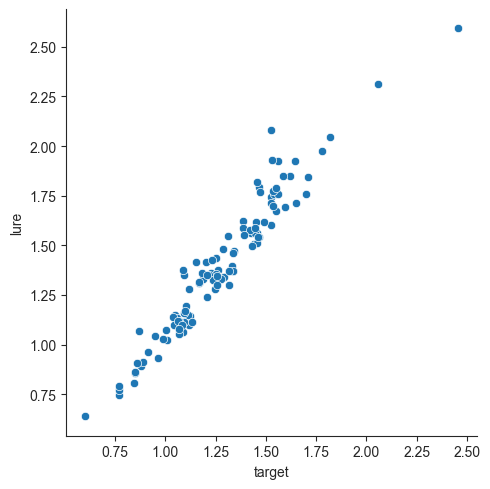

In [17]:
sns.relplot(data=response_time, x="target", y="lure");

Sometimes, we have an independent variable that varies across multiple numeric values, and a dependent variable that may be related to that independent variable. We can visualize this type of relationship using a *line plot*.

In the Osth & Fox (2019) dataset, the main question of interest was whether lag between rearranged pairs would affect the false-alarm rate. Let's get the mean probability of responding "old" for each subject and lag.

In [18]:
lures = (
    data.filter(pl.col("probe_type") == "lure")
    .group_by("subj", "lag")
    .agg(
        pl.col("response").mean(),
        pl.col("RT").mean()
    )
    .sort("subj", "lag")
)
lures.head(10)

subj,lag,response,RT
i64,i64,f64,f64
101,1,0.0625,1.723833
101,2,0.1875,1.795167
101,3,0.0625,1.745646
101,4,0.125,2.085083
101,5,0.104167,2.270312
102,1,0.333333,1.06575
102,2,0.208333,1.057562
102,3,0.166667,1.131146
102,4,0.3125,1.052354


Now we can plot false-alarm rate as it varies by lag, to see if there seems to be a relationship there.

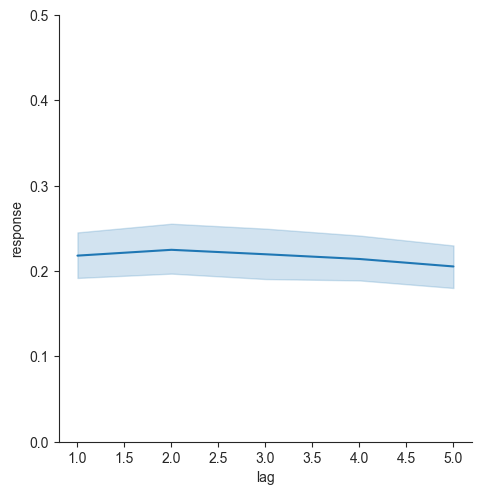

In [19]:
g = sns.relplot(data=lures, x="lag", y="response", kind="line")
g.set(ylim=(0, 0.5));

Here, we've used the FacetGrid object that Seaborn returns to set a property of the figure after making it. We used the `ylim` parameter to indicate that the y-axis should range from 0 (the lowest possible false-alarm rate) to 0.5 (a pretty high false-alarm rate). The plot shows bootstrap confidence intervals, similar to what we had before in our bar plots. Here, there is a confidence *band* that connects the different confidence intervals at each lag.

The plot makes it easy to see that there isn't an obvious relationship between false alarms and lag. There may be a slight trend toward a decrease in false-alarm rate with lag, but it probably isn't statistically reliable.

See the Seaborn documentation for more information about [visualizing statistical relationships](https://seaborn.pydata.org/tutorial/relational.html).